In [2]:
import os
from pathlib import Path
import re
import subprocess
from math import log10, floor
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from copy import deepcopy
import pandas as pd
import itertools
from pptx import Presentation
from pptx.util import Inches

from pymatgen.ext.matproj import MPRester, MPRestError
from monty.serialization import loadfn, dumpfn
from pymatgen import Structure, Composition
from pymatgen.analysis.reaction_calculator import ComputedEntry, ComputedReaction
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.analysis.defects.utils import ChargeDensityAnalyzer
from pymatgen.util.plotting import pretty_plot, periodic_table_heatmap
from pymatgen.command_line.bader_caller import BaderAnalysis
from pymatgen.core import periodic_table
from pymatgen.core.sites import Site, PeriodicSite
from pymatgen.core.bonds import CovalentBond, bond_lengths
from pymatgen.io.vasp.outputs import Elfcar, VolumetricData, Chgcar

#from slicing_helper import UnitCellData, generate_3d, take_slice, plot_slice, plot_3d, contour_map

from scipy.stats import linregress, skew, describe
from scipy.interpolate import RegularGridInterpolator
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error

In [5]:
PROJECT = 'SCAN project'

workdir = Path(re.sub("(?<={})[\w\W]*".format(PROJECT), "", '/mnt/c/Users/Ayush/Desktop/scan-error-analysis/'))
os.chdir(workdir)

data_dir = workdir / 'data/SCAN_bader_data'

In [6]:
print(workdir)
print(data_dir)

/mnt/c/Users/Ayush/Desktop/scan-error-analysis
/mnt/c/Users/Ayush/Desktop/scan-error-analysis/data/SCAN_bader_data


In [7]:
class Datapoint:
    
    def __init__(self, label: str, attributes: dict = {}):
        self.label = label 
        self.attributes = attributes
        
    def has_attr(self, attr: str):
        return attr in self.attributes.keys()
    
    def get_attr(self, attr: str):
        assert self.has_attr(attr), 'Element \'{0}\' does not have attribute \'{1}\''.format(self.label, attr)
        return self.attributes[attr]
    
    @property
    def attribute_list(self):
        return list(self.attributes.keys())
    
    def add_attr(self, attrs: dict):
        self.attributes.update(attrs)
        
    
class Collection:
    
    def __init__(self, datapoints: list = []):
        self.datapoints = datapoints
        
    @property
    def labels(self):
        return [dp.label for dp in self.datapoints]
    
    def add_datapoint(self, datapoint: Datapoint):
        self.datapoints.append(datapoint)
        
    def add_attr(self, label: str, attr: dict):
        dp = self.get_datapoint(label)
        dp.add_attr(attr)
        
    def has_datapoint(self, label: str):
        return label in self.labels
        
    def get_datapoint(self, label: str):
        assert self.has_datapoint(label), 'This collection doesn\'t have a datapoint with label \'{}\''.format(label)
        return self.datapoints[self.labels.index(label)]
    
    def by_attr(self, attr: str):
        assert all([dp.has_attr(attr) for dp in self.datapoints]), 'Not all datapoints in collection have attribute \'{}\''.format(attr)
        return [dp.get_attr(attr) for dp in self.datapoints]
    
    def make_dict(self, attr: str):
        return dict(zip(self.labels, self.by_attr(attr)))

In [8]:
a = Datapoint('a', {'weight':5, 'height':2})
b = Datapoint('b', {'weight':7, 'height':1})
c = Datapoint('c', {'weight':3, 'height':0.1})
collection = Collection([a, b, c])

In [9]:
collection.by_attr('height')

[2, 1, 0.1]

In [10]:
def run_bader(printouts=True): 
    compound_list = []
    elfcar_dict = {}
    for d1 in data_dir.iterdir():
        os.chdir(d1)
        
        formula = str(os.getcwd()).replace(str(data_dir) + '/', '')
        if printouts:
            print('---------------------------------------------------------------')
            print(formula)
        compound_list.append(formula)
        
        elfcar_dict[formula] = Elfcar.from_file('ELFCAR')
        
        if not os.path.isfile('CHGREF'):
            aeccar0, aeccar2 = Chgcar.from_file('AECCAR0'), Chgcar.from_file('AECCAR2')
            chgref = aeccar0 + aeccar2
            chgref.write_file('CHGREF')
            if printounts:
                print('\tCHGREF written')
        elif printouts:
            print('\tCHGREF already exists')
        
        if not os.path.isfile('ACF.dat'):
            subprocess.run(['bader', '-p', 'atom_index', 'CHGCAR', '-ref', 'CHGREF'])
            if printouts:
                print('\tBADER complete')
        elif printouts:
            print('\tBADER already ran')

    os.chdir(workdir)
    return compound_list, elfcar_dict

In [12]:
compounds, elfcar_dict = run_bader(printouts=True)

---------------------------------------------------------------
AgO
	CHGREF already exists
	BADER already ran
---------------------------------------------------------------
AuCl3
	CHGREF already exists
	BADER already ran
---------------------------------------------------------------
BaO2
	CHGREF already exists
	BADER already ran
---------------------------------------------------------------
CaO
	CHGREF already exists
	BADER already ran
---------------------------------------------------------------
CdO
	CHGREF already exists
	BADER already ran
---------------------------------------------------------------
CsCl
	CHGREF already exists
	BADER already ran
---------------------------------------------------------------
CsO2
	CHGREF already exists
	BADER already ran
---------------------------------------------------------------
CuO
	CHGREF already exists
	BADER already ran
---------------------------------------------------------------
FeCl3
	CHGREF already exists
	BADER already ran
---

In [13]:
print(compounds)
elfcar_dict

['AgO', 'AuCl3', 'BaO2', 'CaO', 'CdO', 'CsCl', 'CsO2', 'CuO', 'FeCl3', 'GaCl3', 'HgO', 'InCl3', 'IrCl3', 'IrO2', 'KCl', 'MgO', 'NaCl', 'RbCl', 'RhCl3', 'SnO', 'SrO', 'SrO2', 'ZnO']


{'AgO': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd72c772520>,
 'AuCl3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd72c7729d0>,
 'BaO2': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd72c772cd0>,
 'CaO': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd72c7726a0>,
 'CdO': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd71cee53d0>,
 'CsCl': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd71c1f7d60>,
 'CsO2': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd72c772d00>,
 'CuO': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd71c1f7d90>,
 'FeCl3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd71c1f7f70>,
 'GaCl3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd71c1fcbb0>,
 'HgO': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd71c1f7fa0>,
 'InCl3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd71c180eb0>,
 'IrCl3': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd71c180ee0>,
 'IrO2': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd71c180e20>,
 'KCl': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd71c188e50>,
 'MgO': <pymatgen.io.vasp.outputs.Elfcar at 0x7fd71c18ca30>,
 'NaCl': <

In [14]:
def retrieve_index_masks():
    masks = {}
    for d1 in data_dir.iterdir():
        os.chdir(d1)
        formula = str(os.getcwd()).replace(str(data_dir) + '/', '')
        masks[formula] = Chgcar.from_file('AtIndex.dat')
    os.chdir(workdir)
    return masks    

In [15]:
index_masks = retrieve_index_masks()
index_masks

{'AgO': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd71c1f7190>,
 'AuCl3': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd72c760c70>,
 'BaO2': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd72c7665b0>,
 'CaO': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd72c7daee0>,
 'CdO': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd72c7daf40>,
 'CsCl': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd72c7da5b0>,
 'CsO2': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd72c7dae80>,
 'CuO': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd71c2b3550>,
 'FeCl3': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd71c2b3520>,
 'GaCl3': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd71c1f7f10>,
 'HgO': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd71c1f7a30>,
 'InCl3': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd72c7941c0>,
 'IrCl3': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd72c794eb0>,
 'IrO2': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd72c7944f0>,
 'KCl': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd72c7940d0>,
 'MgO': <pymatgen.io.vasp.outputs.Chgcar at 0x7fd71c1cfc10>,
 'NaCl': <

In [16]:
print(compounds)

['AgO', 'AuCl3', 'BaO2', 'CaO', 'CdO', 'CsCl', 'CsO2', 'CuO', 'FeCl3', 'GaCl3', 'HgO', 'InCl3', 'IrCl3', 'IrO2', 'KCl', 'MgO', 'NaCl', 'RbCl', 'RhCl3', 'SnO', 'SrO', 'SrO2', 'ZnO']


In [18]:
os.chdir(workdir)
error_data = pd.read_json(loadfn('data/error_data.json'))
error_dict = {}
for i, j in error_data.iterrows():
    error_dict[j.Formula] = j.Error

In [19]:
data = Collection()

for f in compounds:
    dp = Datapoint(label=f, 
                   attributes = {'error':error_dict[f], 
                                 'num_bader_wells':int(max(index_masks[f].data['total'].flatten()))})
    data.add_datapoint(dp)

In [20]:
for f in compounds:
    data.add_attr(f, {'lattice_params': elfcar_dict[f].structure.lattice.abc})

In [21]:
data.make_dict('error')

{'AgO': -0.2336947692,
 'AuCl3': -0.2002423273,
 'BaO2': 0.4236453948,
 'CaO': 0.1244621533,
 'CdO': 0.2705298873,
 'CsCl': 0.2429573643,
 'CsO2': 0.16670939880000002,
 'CuO': 0.1023461173,
 'FeCl3': 0.1623330378,
 'GaCl3': 0.718637847,
 'HgO': 0.3358690683,
 'InCl3': 1.1217346382,
 'IrCl3': 0.229973115,
 'IrO2': 0.0005017585,
 'KCl': 0.1898299079,
 'MgO': 0.2250196912,
 'NaCl': 0.21032335330000002,
 'RbCl': 0.2020366027,
 'RhCl3': -0.3334765351,
 'SnO': 0.28885640020000003,
 'SrO': 0.1629351759,
 'SrO2': 0.22356188940000002,
 'ZnO': 0.4352991473}

In [22]:
data.make_dict('num_bader_wells')

{'AgO': 4,
 'AuCl3': 16,
 'BaO2': 3,
 'CaO': 2,
 'CdO': 2,
 'CsCl': 2,
 'CsO2': 3,
 'CuO': 4,
 'FeCl3': 24,
 'GaCl3': 8,
 'HgO': 6,
 'InCl3': 8,
 'IrCl3': 8,
 'IrO2': 6,
 'KCl': 2,
 'MgO': 2,
 'NaCl': 2,
 'RbCl': 2,
 'RhCl3': 8,
 'SnO': 4,
 'SrO': 2,
 'SrO2': 3,
 'ZnO': 2}

In [23]:
data.make_dict('lattice_params')

{'AgO': (3.219765500642865, 3.219765500642865, 5.543821722057989),
 'AuCl3': (6.62380859410717, 6.595533529075263, 11.012902),
 'BaO2': (3.824589411210176, 3.8245891539365373, 4.38579995956154),
 'CaO': (3.3872665149601087, 3.3872668820087086, 3.387265),
 'CdO': (3.336265038900387, 3.336264245710912, 3.336264),
 'CsCl': (4.121282, 4.121282, 4.121282),
 'CsO2': (4.353303993124303, 4.353303649580167, 4.748000891368915),
 'CuO': (2.885619316727347, 2.885619855890931, 5.150391607440059),
 'FeCl3': (6.084153028925144, 6.0841974569772965, 17.865694083338074),
 'GaCl3': (6.836185993158758, 7.010593449027621, 6.933478297002306),
 'HgO': (3.648403, 3.648404026051528, 8.833265),
 'InCl3': (9.573449006309378, 9.572045809541551, 3.406463002245731),
 'IrCl3': (6.058928973920473, 6.058928976502117, 6.096418991838242),
 'IrO2': (3.169541, 4.494889, 4.494889),
 'KCl': (4.4345853863196725, 4.434585333068358, 4.434586),
 'MgO': (2.9644988659233786, 2.9644989642835093, 2.964498),
 'NaCl': (3.951402922131

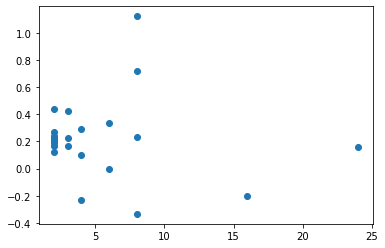

In [24]:
plt.scatter(data.by_attr('num_bader_wells'), data.by_attr('error'))

In [25]:
def create_mask(index_mask, index):
    dt = index_mask.data['total']
    shape = dt.shape
    flat = dt.flatten()
    for i in range(len(flat)):
        flat[i] = 1 if int(flat[i]) == index else 0
    mask = flat.reshape(shape)
    return mask

In [26]:
def apply_mask(elfcar, mask):
    dt = elfcar.data['total']
    s1, s2 = dt.shape, mask.shape
    factor = s2[0] / s1[0]
    flat, mf = dt.flatten(), mask.flatten()
    for i in range(len(flat)):
        flat[i] = flat[i] * mf[int(i*factor)]
    masked = flat.reshape(s1)
    return masked

In [27]:
def filter_zeros(mask):
    mf = mask.flatten()
    return [n for n in mf if n != 0]

In [28]:
for f in compounds:
    s1, s2 = index_masks[f].data['total'].shape, elfcar_dict[f].data['total'].shape
    print(s1[0] / s2[0], s1[1] / s2[1], s1[2] / s2[2])

2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0
2.0 2.0 2.0


In [29]:
def create_mask_dict():
    elf, alpha = {}, {}
    for f in compounds:
        el, al = elfcar_dict[f], elfcar_dict[f].get_alpha()
        masked_e, masked_a = [], []
        for i in range(1, data.get_datapoint(f).get_attr('num_bader_wells') + 1):
            mask = create_mask(index_masks[f], i)
            masked_e.append(apply_mask(el, mask))
            masked_a.append(apply_mask(al, mask))
        elf[f], alpha[f] = masked_e, masked_a
    return elf, alpha

In [30]:
masked_elf, masked_alpha = create_mask_dict()

In [23]:
def plot_histogram(f, mode='elf'):
    if mode == 'elf':
        data = masked_elf[f]
        disp = 'ELF'
    elif mode == 'alpha':
        data = masked_alpha[f]
        disp = 'α'
        
    processed = []
    for dat in data:
        processed.append([dp for dp in dat.flatten() if dp != 0.0])
    
        
    nbins = 100
    plt.hist(processed, 
             nbins, 
             histtype='bar', 
             stacked=True,
             label=['Bader Well {}'.format(i + 1) for i in range(len(dat))],
    )
    #plt.legend(loc="upper right")
    if mode == 'alpha':
        plt.yscale('log')
    
    plt.title('Distribution of {0} Values Across Bader Wells for {1}'.format(disp, f), fontsize=20)
    plt.xlabel('{} Value'.format(disp), fontsize=16)
    plt.ylabel('Count', fontsize=16)

    plt.show()

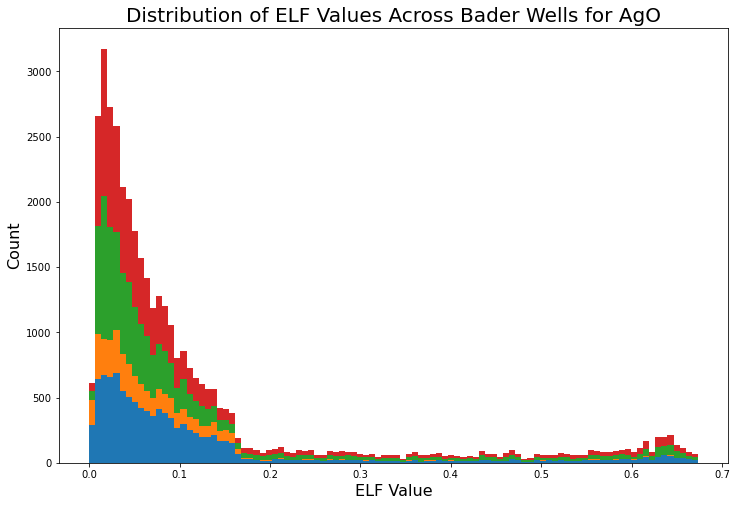

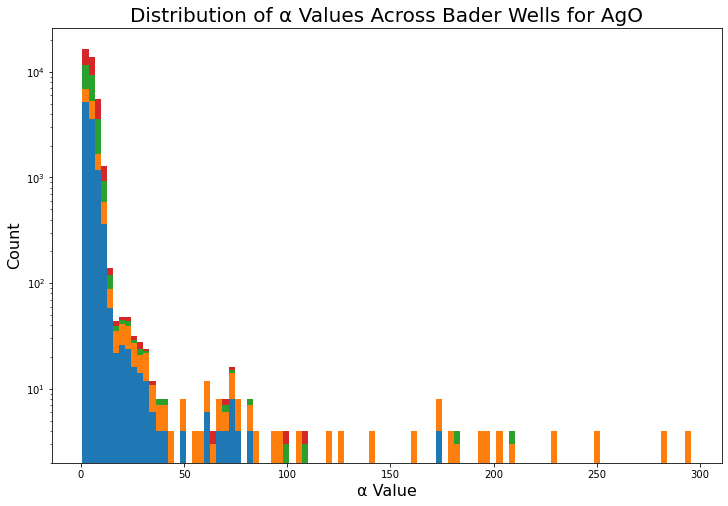

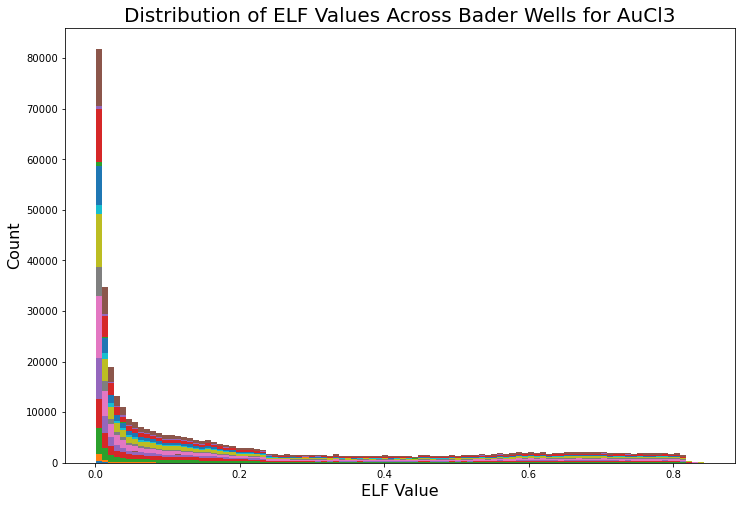

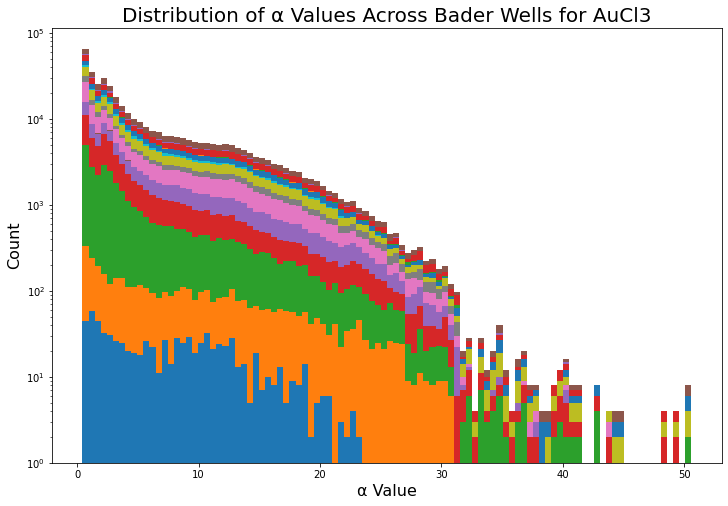

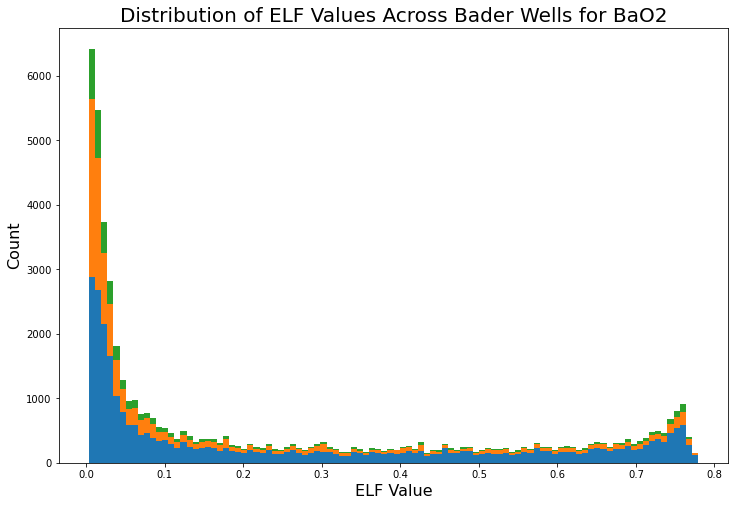

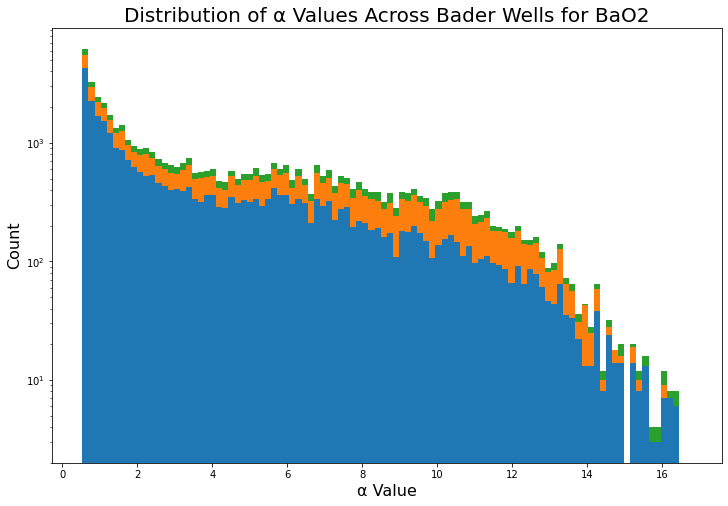

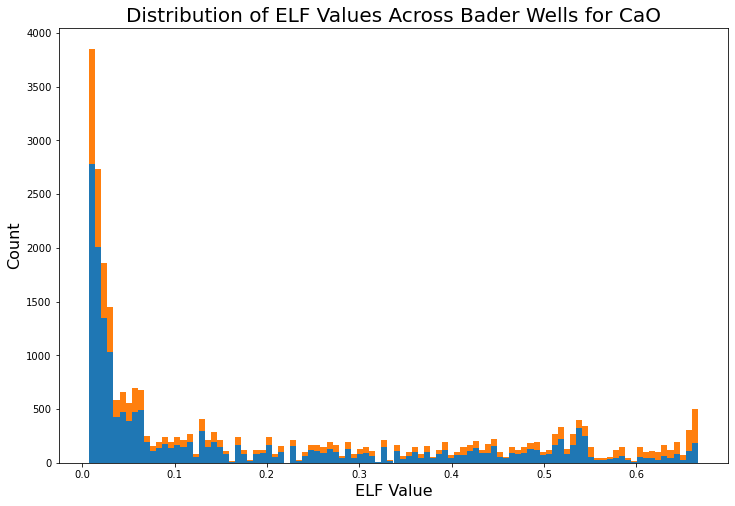

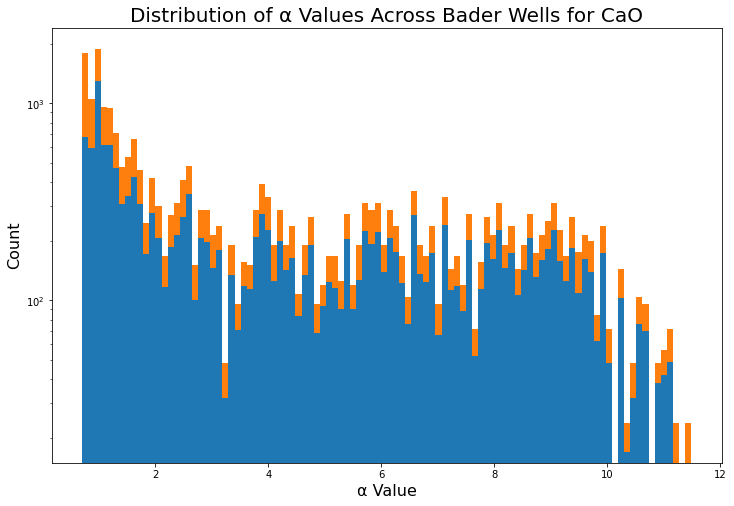

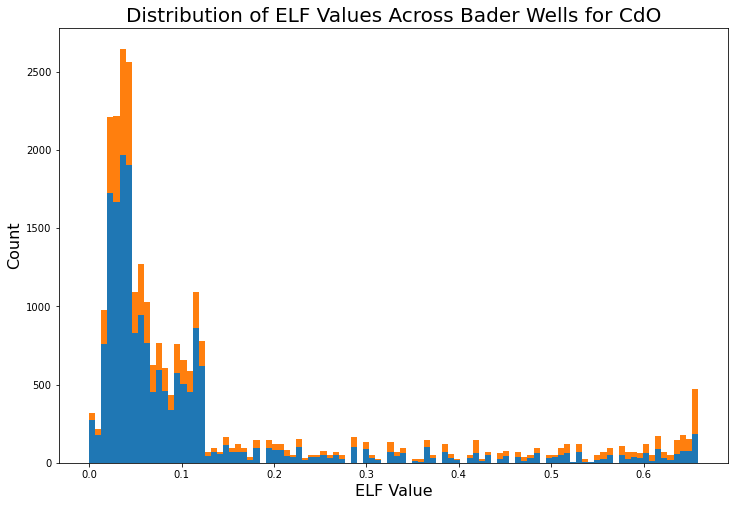

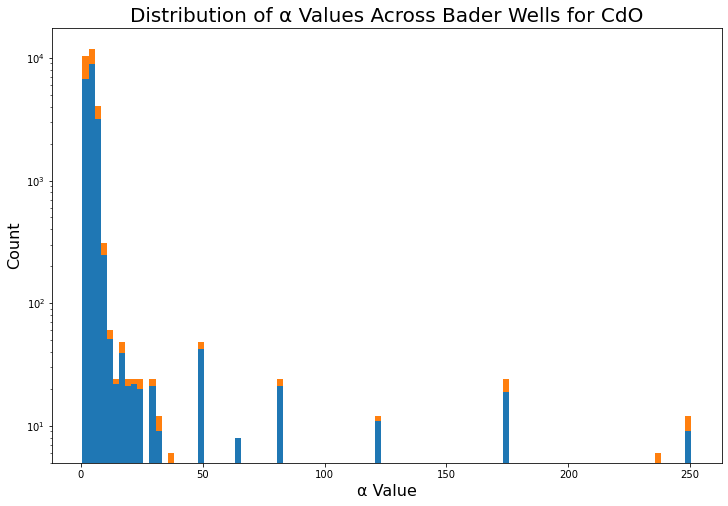

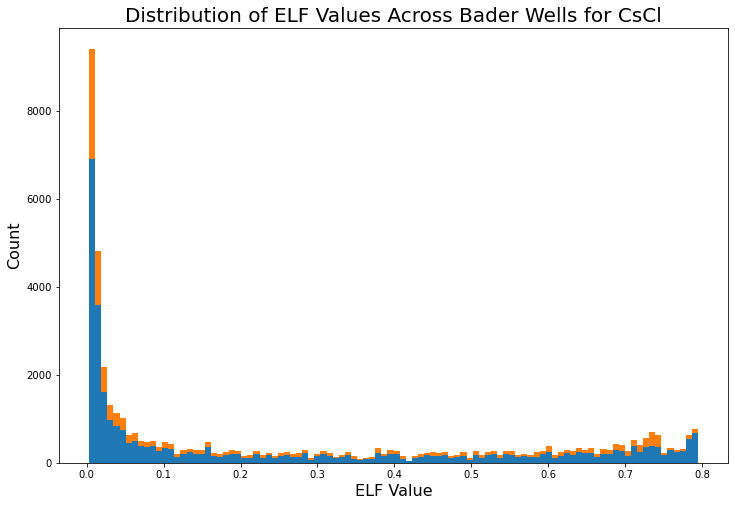

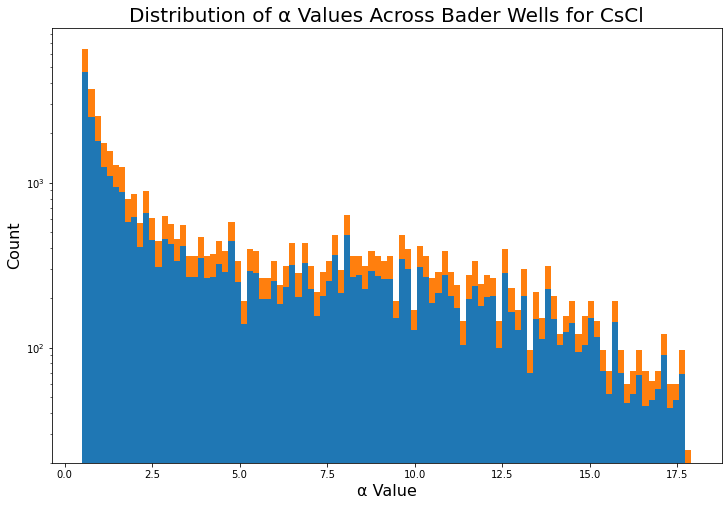

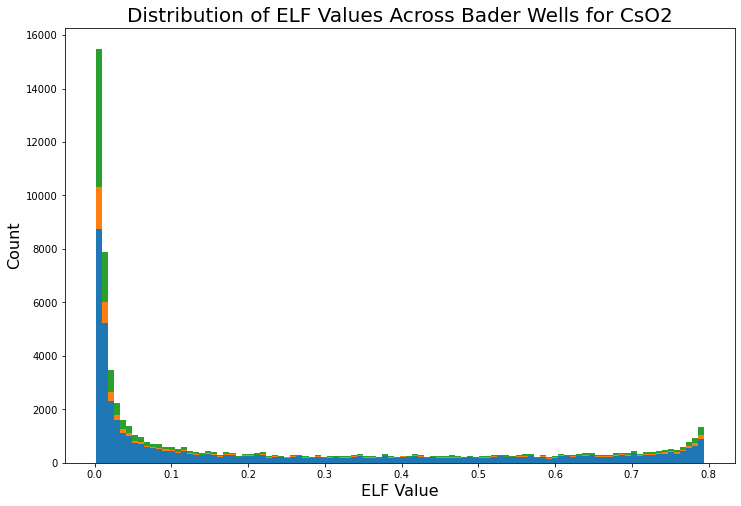

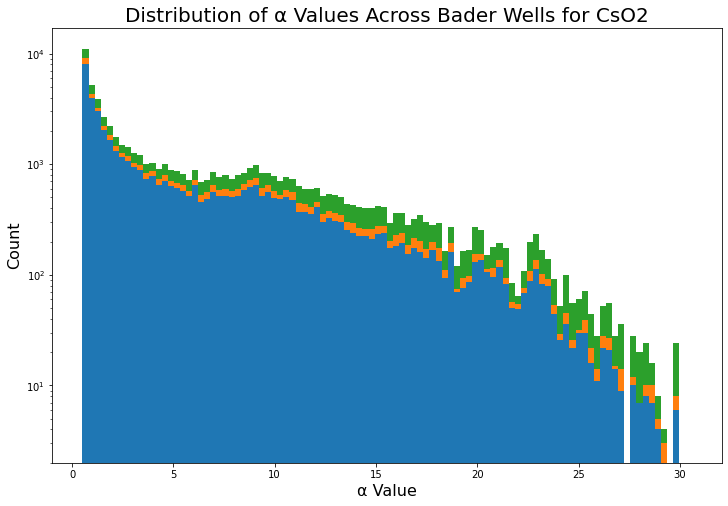

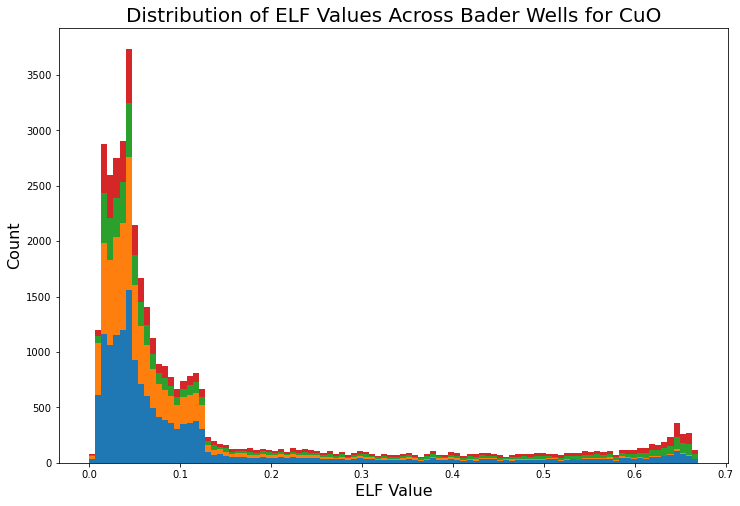

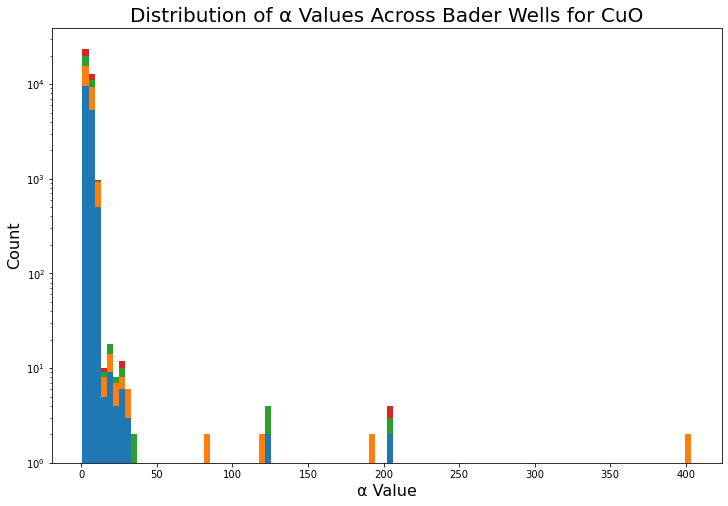

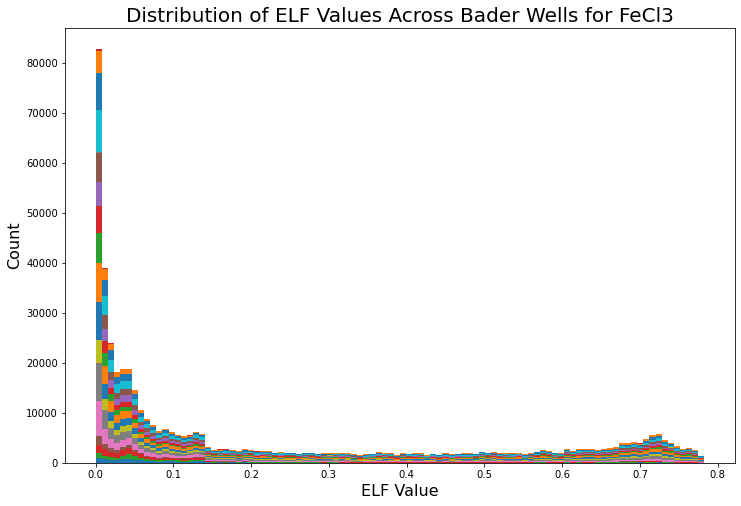

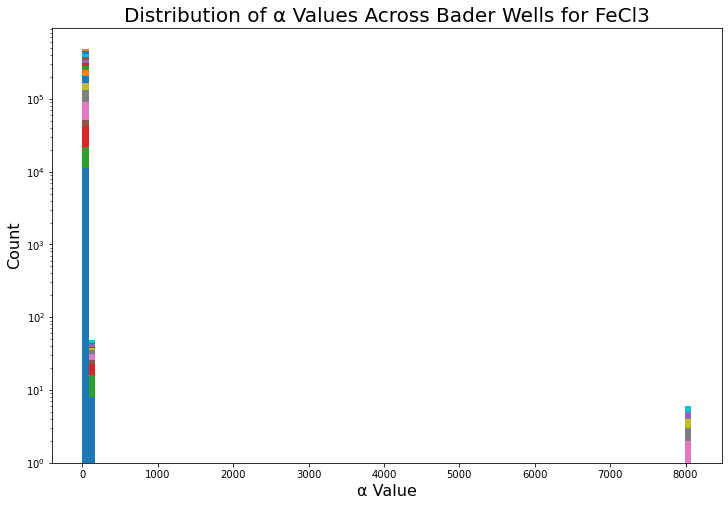

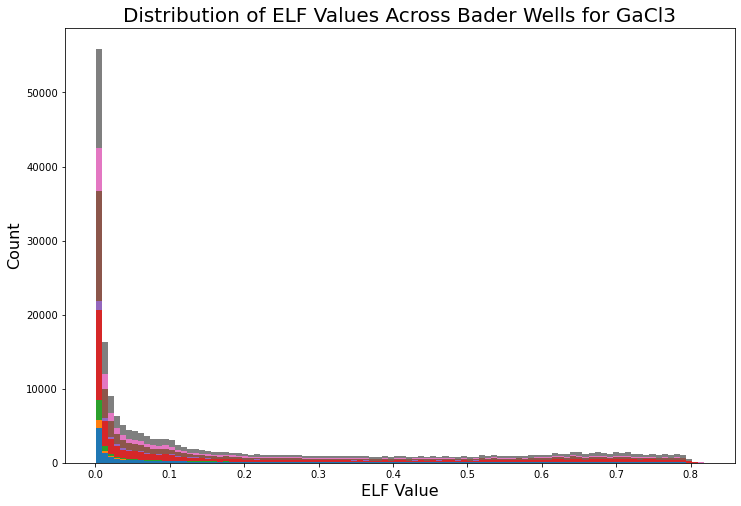

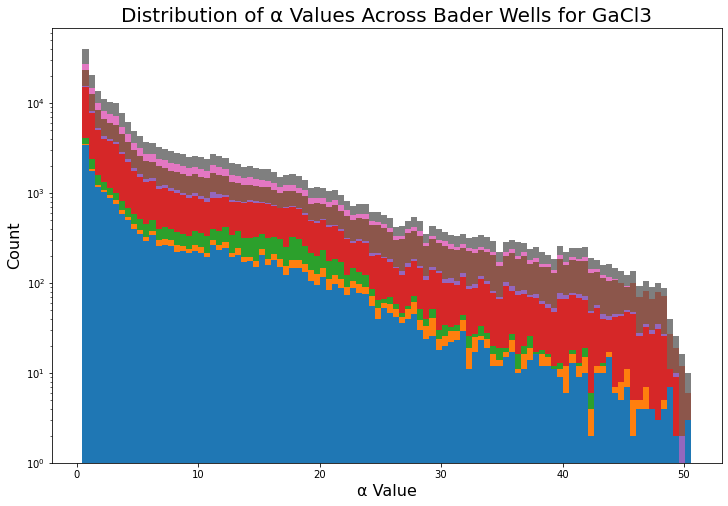

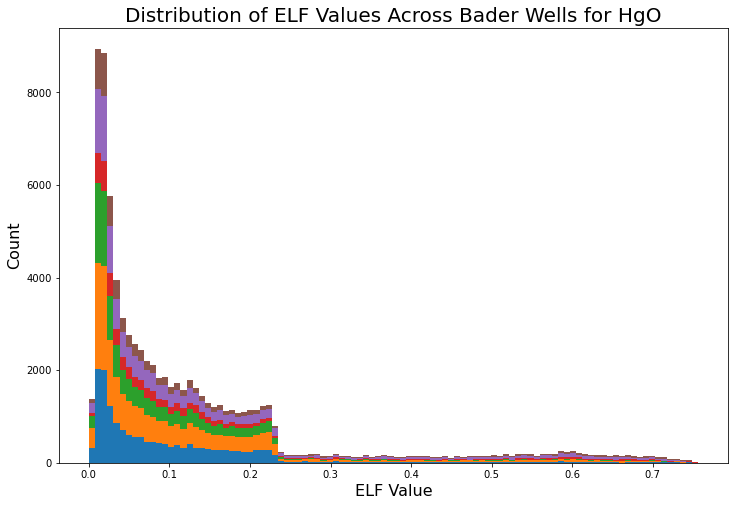

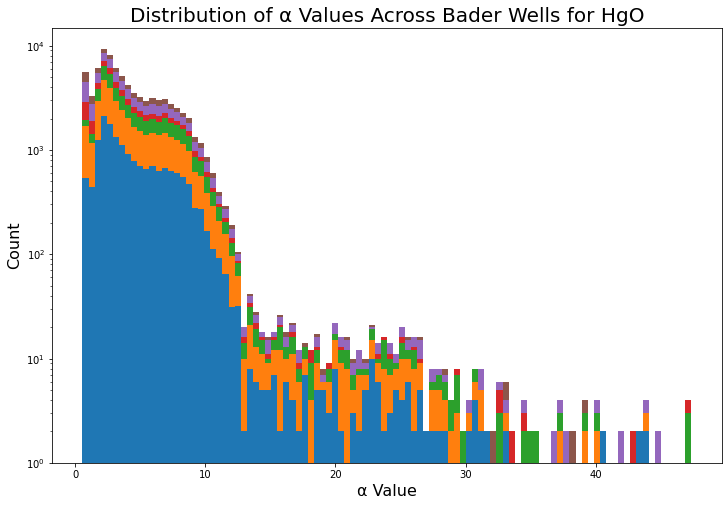

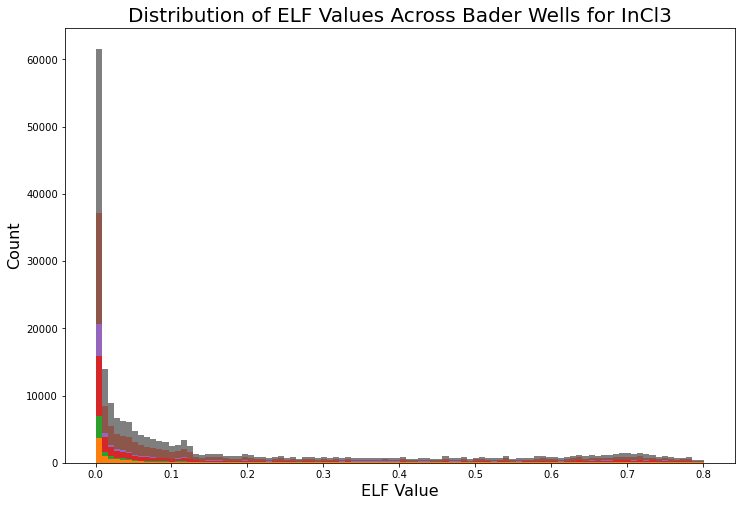

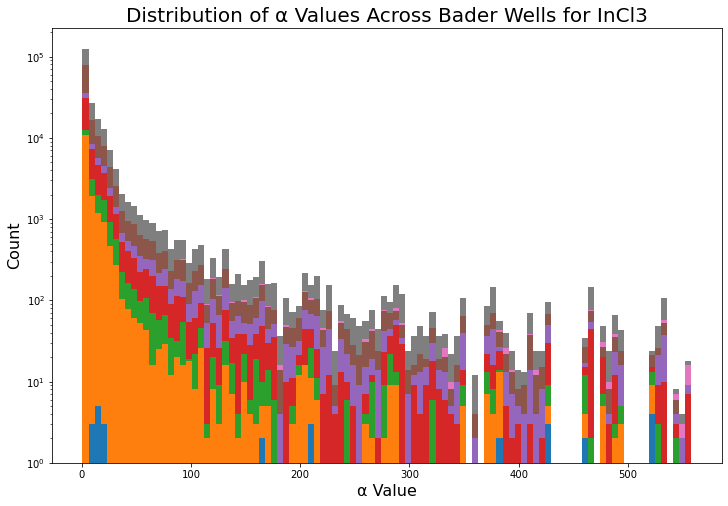

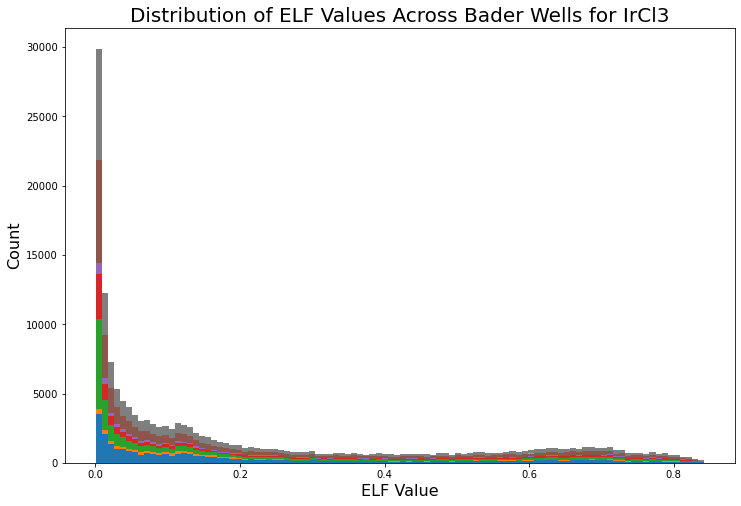

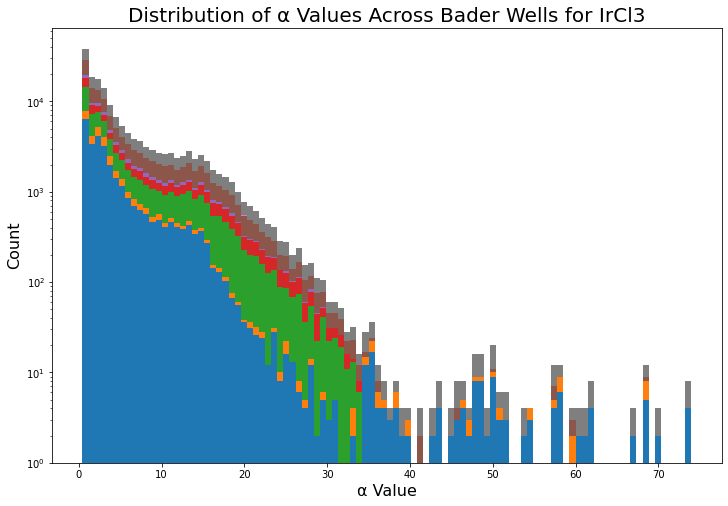

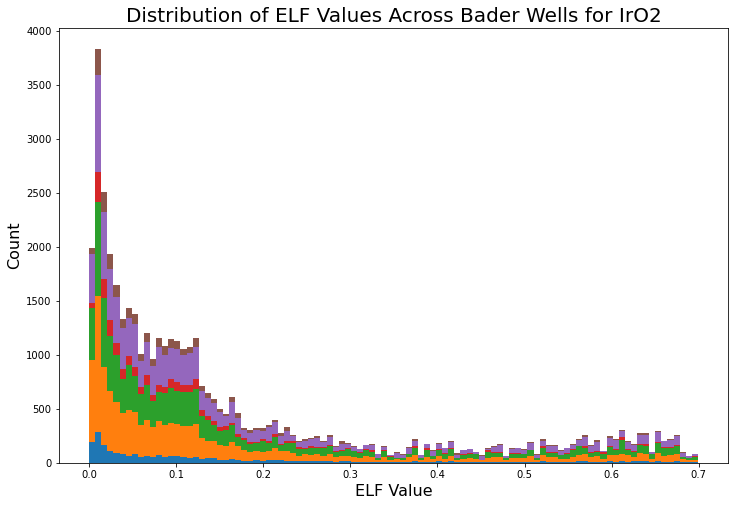

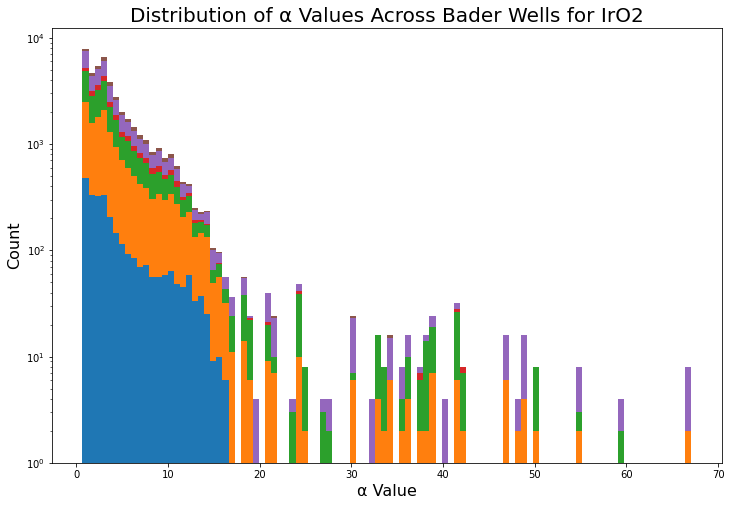

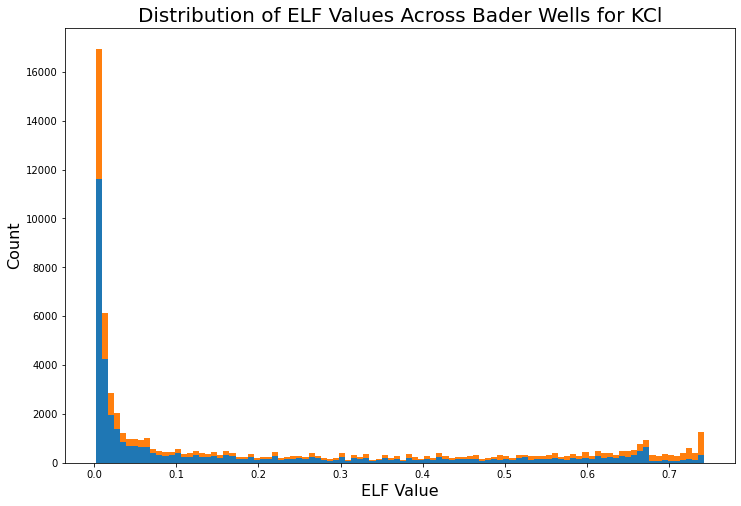

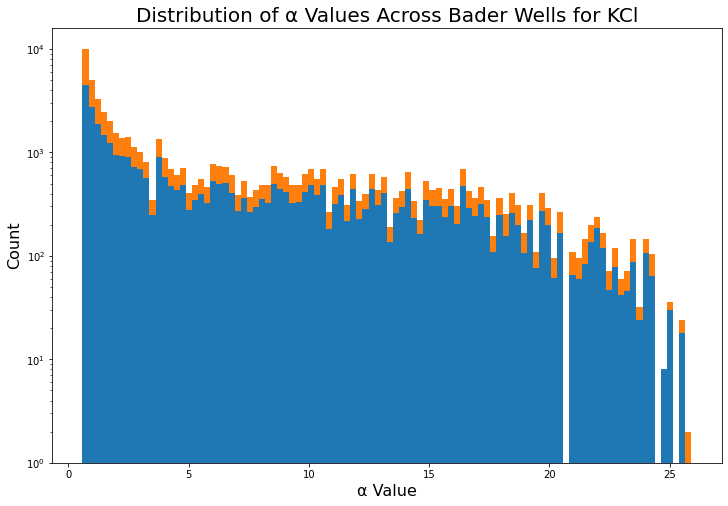

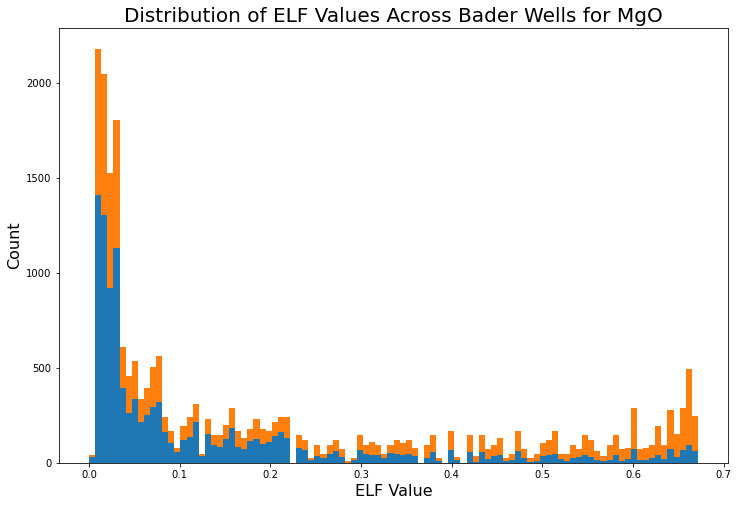

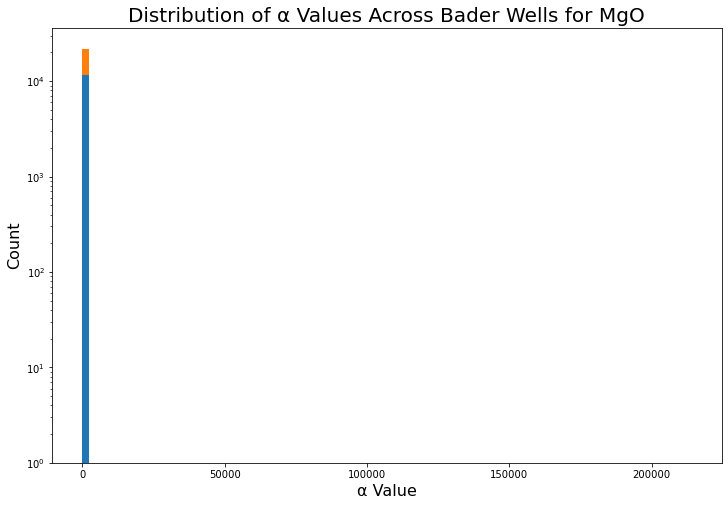

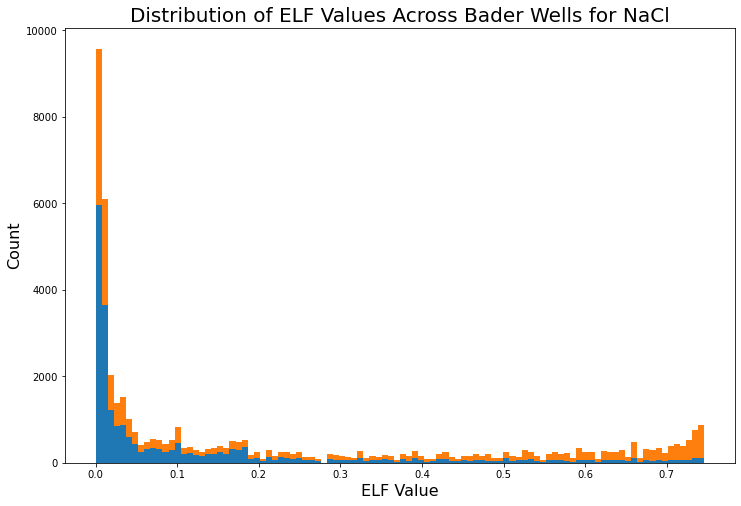

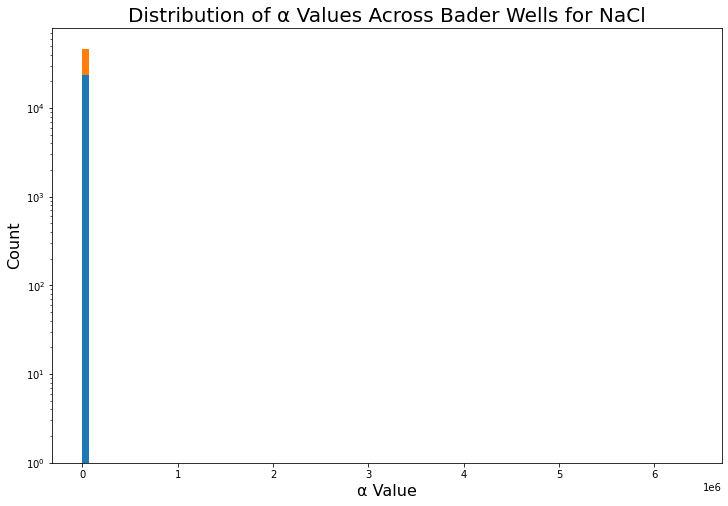

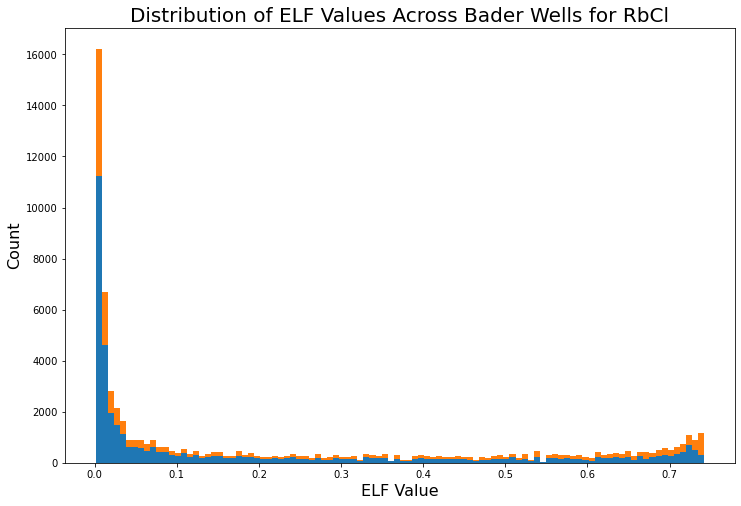

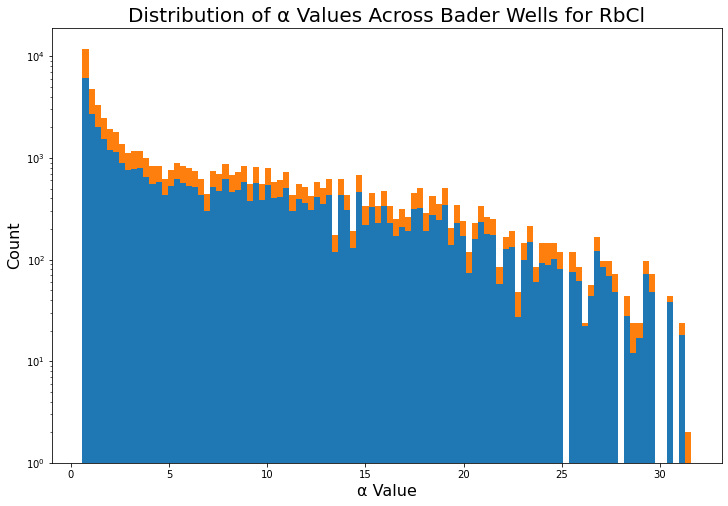

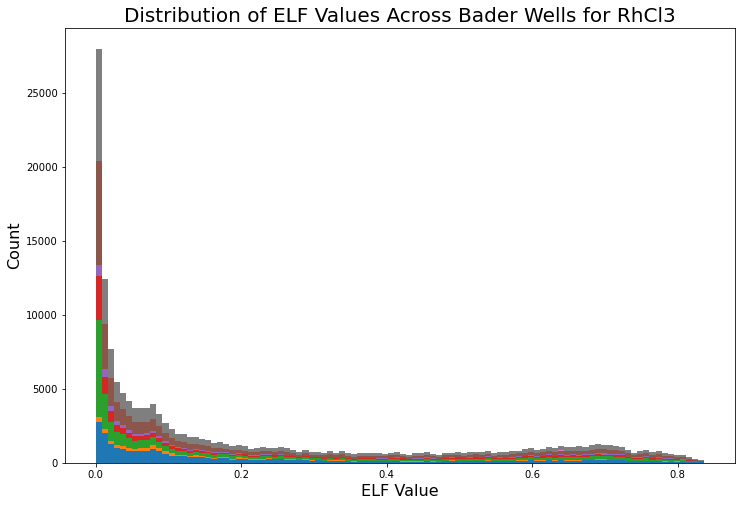

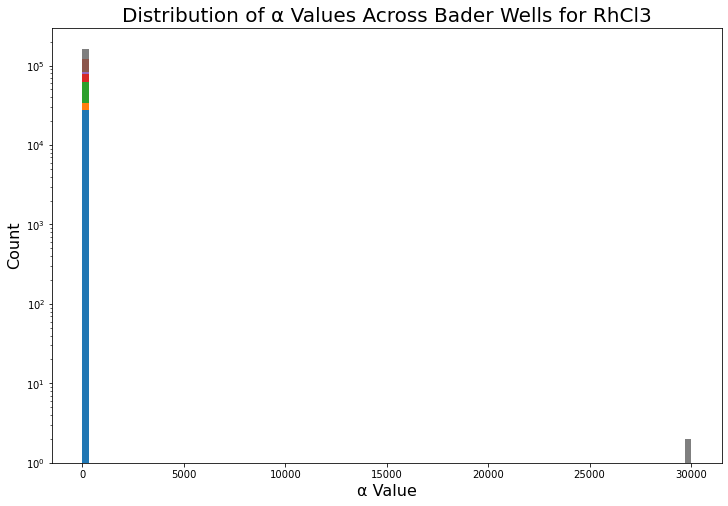

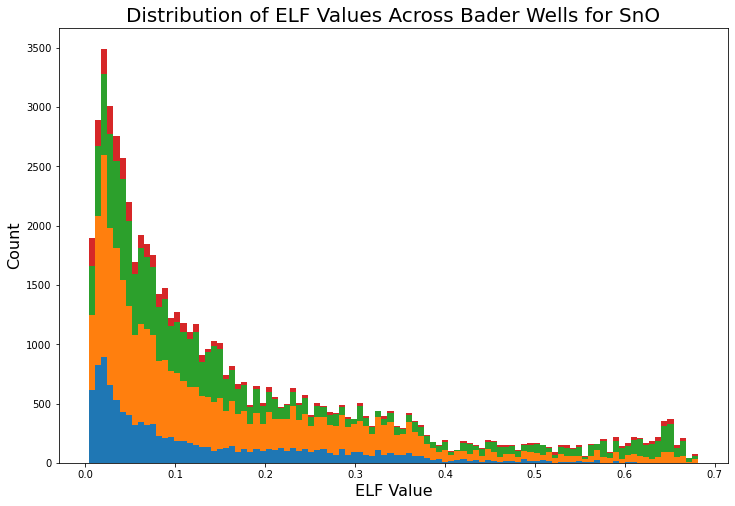

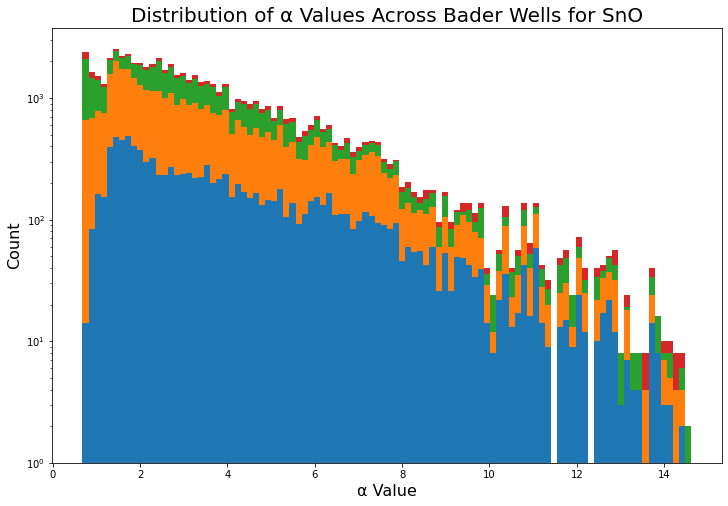

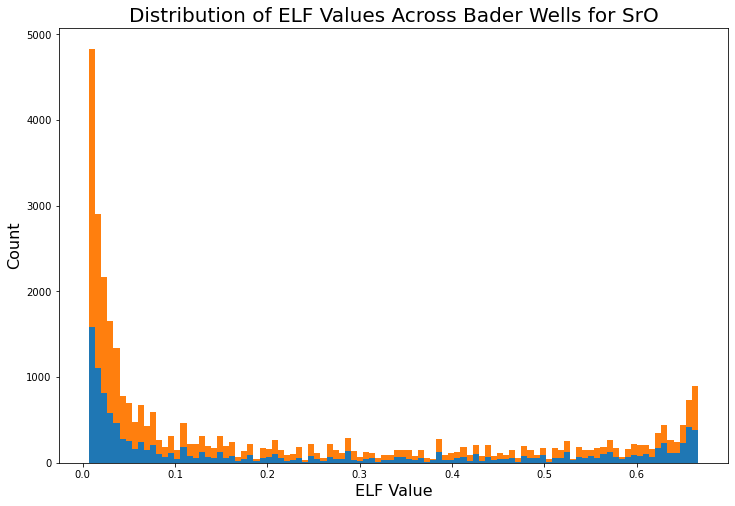

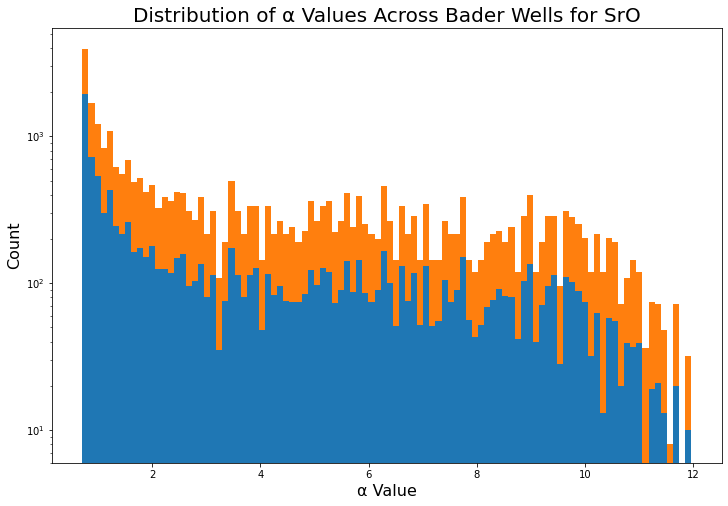

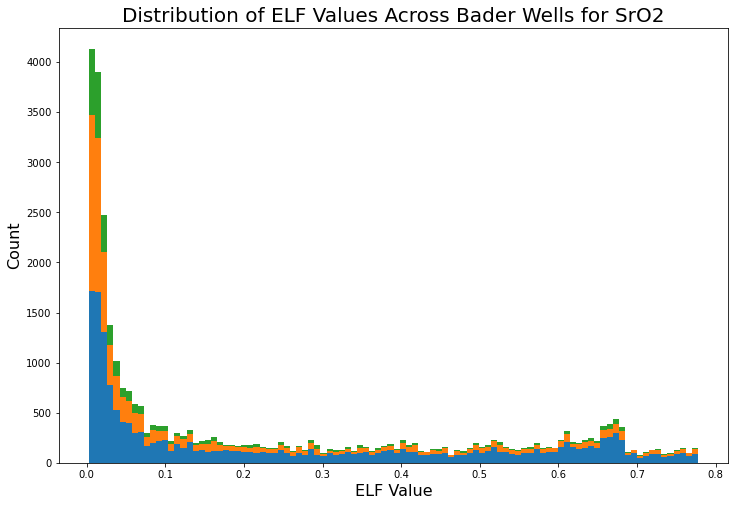

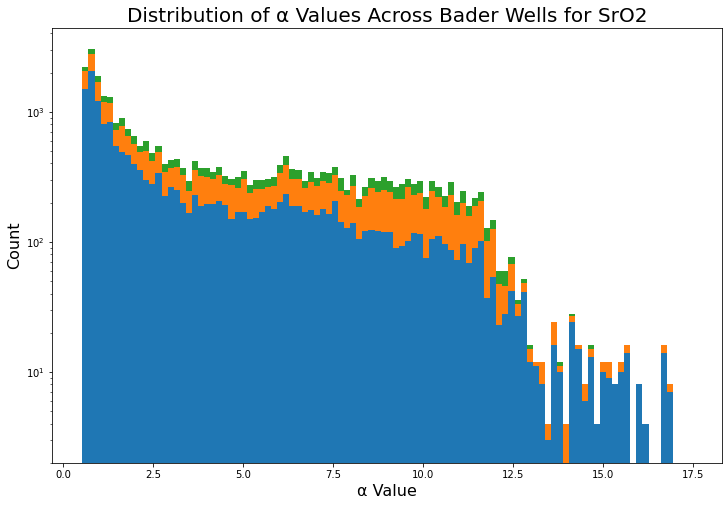

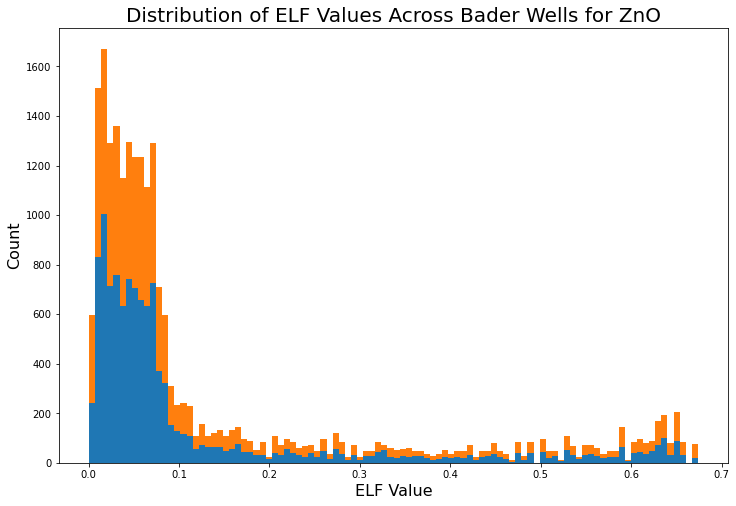

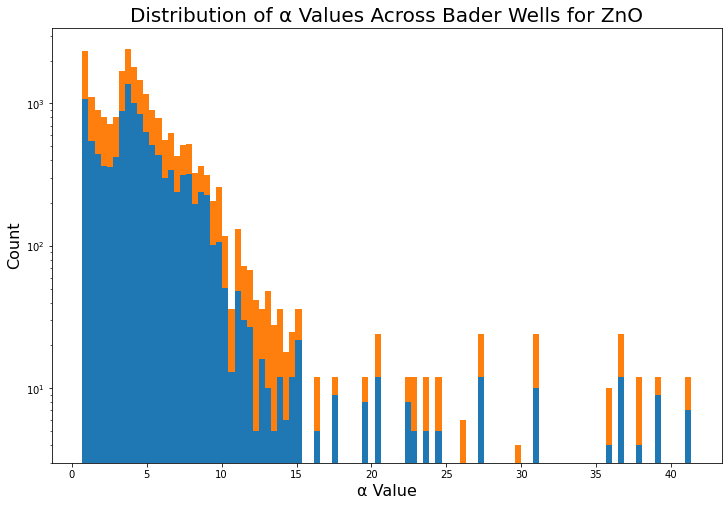

In [102]:
for f in masked_elf.keys():
    plot_histogram(f, mode='elf')
    plot_histogram(f, mode='alpha')